### Import Modules

In [1]:
import os
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import Python Packages for data manipulation, data pipelines, and databases
import numpy as np
import pyarrow # foundation for polars
import polars as pl # DataFrame work superior to Pandas

# Plotting
import matplotlib.pyplot as plt
# Display static plots directly in the notebook output 
%matplotlib inline
# create stylized visualizations, including heat maps
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (RandomizedSearchCV, 
                                    TimeSeriesSplit)
from sklearn.model_selection import cross_validate

# utilized in all possible subsets classification work
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# needed for randomized search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# metrics in xgboost tuning and final model evaluation
from sklearn.metrics import (accuracy_score,
                             classification_report, 
                             roc_curve, 
                             roc_auc_score,
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix,
                             precision_score,
                             recall_score,
                             f1_score
                            )

# XGBoost Package... more complete than SciKit-Learn boosting methods
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, plot_importance

# import yfinance as yf  # used earlier to obtain the price series
import yfinance as yf

import warnings
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore') 

### Import Data

In [2]:
symbol = 'DKNG'
start_date = '2000-01-01'
end_date = '2025-07-04'

ticker = yf.Ticker(symbol)
historical_data = ticker.history(start = start_date, end = end_date, period = '1mo')

historical_data.to_csv("DKNG_historical_data.csv")

### Polars Dataframe

In [3]:
DKNG = pl.read_csv("DKNG_historical_data.csv", try_parse_dates=True)

# drop useless columns Dividends and StockSplits
DKNG = DKNG.drop(['Dividends', 'Stock Splits'])

# create lag price features
DKNG = DKNG.with_columns((pl.col('Close')).shift().alias('CloseLag1'))
DKNG = DKNG.with_columns((pl.col('CloseLag1')).shift().alias('CloseLag2'))
DKNG = DKNG.with_columns((pl.col('CloseLag2')).shift().alias('CloseLag3'))

# create high-minus-low (HML) for day and its lags
DKNG = DKNG.with_columns((pl.col('High') - pl.col('Low')).alias('HML'))
DKNG = DKNG.with_columns((pl.col('HML')).shift().alias('HMLLag1'))
DKNG = DKNG.with_columns((pl.col('HMLLag1')).shift().alias('HMLLag2'))
DKNG = DKNG.with_columns((pl.col('HMLLag2')).shift().alias('HMLLag3'))

# create a net change for the day as the open minus closing price OMC
# also create the corresponding lag metrics
DKNG = DKNG.with_columns((pl.col('Open') - pl.col('Close')).alias('OMC'))
DKNG = DKNG.with_columns((pl.col('OMC')).shift().alias('OMCLag1'))
DKNG = DKNG.with_columns((pl.col('OMCLag1')).shift().alias('OMCLag2'))
DKNG = DKNG.with_columns((pl.col('OMCLag2')).shift().alias('OMCLag3'))

# create volume lag metrics
DKNG = DKNG.with_columns((pl.col('Volume')).shift().alias('VolumeLag1'))
DKNG = DKNG.with_columns((pl.col('VolumeLag1')).shift().alias('VolumeLag2'))
DKNG = DKNG.with_columns((pl.col('VolumeLag2')).shift().alias('VolumeLag3'))

# compute 10-day exponential moving averages of closing prices
# compute acround CloseLag1 to avoid any "leakage" in explanatory variable set
# note also the 10-day buffer between train and test in time-series cross-validation
DKNG = DKNG.with_columns((pl.col('CloseLag1').ewm_mean(half_life=1,ignore_nulls=True)).alias('CloseEMA2'))
DKNG = DKNG.with_columns((pl.col('CloseLag1').ewm_mean(half_life=2,ignore_nulls=True)).alias('CloseEMA4'))
DKNG = DKNG.with_columns((pl.col('CloseLag1').ewm_mean(half_life=4,ignore_nulls=True)).alias('CloseEMA8'))

# log daily returns
DKNG = DKNG.with_columns(np.log(pl.col('Close')/pl.col('CloseLag1')).alias('LogReturn'))

# set volume features to Float64 for subsequent use in Numpy arrays
DKNG = DKNG.with_columns(
    pl.col('Volume').cast(pl.Float64).round(0),
    pl.col('VolumeLag1').cast(pl.Float64).round(0),
    pl.col('VolumeLag2').cast(pl.Float64).round(0),
    pl.col('VolumeLag3').cast(pl.Float64).round(0),
    )

# round other features to three decimal places for reporting and subsequent analytics
DKNG = DKNG.with_columns(
    pl.col('Open').round(3),
    pl.col('High').round(3),    
    pl.col('Low').round(3),
    pl.col('Close').round(3),      
    pl.col('CloseLag1').round(3),
    pl.col('CloseLag2').round(3),  
    pl.col('CloseLag3').round(3),
    pl.col('HML').round(3),  
    pl.col('HMLLag1').round(3),
    pl.col('HMLLag2').round(3),  
    pl.col('HMLLag3').round(3),
    pl.col('OMC').round(3),  
    pl.col('OMCLag1').round(3),
    pl.col('OMCLag2').round(3),  
    pl.col('OMCLag3').round(3), 
    pl.col('CloseEMA2').round(3),
    pl.col('CloseEMA4').round(3), 
    pl.col('CloseEMA8').round(3))
    
# define binary target/response 1 = market price up since previous day, 0 = even or down 
DKNG = DKNG.with_columns(pl.when(pl.col('LogReturn')>0.0).then(pl.lit(1)).otherwise(pl.lit(0)).alias('Target'))

# save to external comma-delimited text file for checking calculations in Excel
DKNG.write_csv("DKNG-with-computed-features.csv")

### DKNG Closing Price over Time

In [40]:
DKNG["Close"].plot.line().properties(width=500, title="DKNG Closing Price")

alt.Chart(...)

### Descriptive Stats

In [4]:
# Drop the rows with null values such as the initial lag rows
DKNG = DKNG.drop_nulls()

# Descriptive statistics
DKNGStatistics = DKNG.drop('Date').describe()

DKNGStatisticsToPrint = DKNGStatistics.transpose(include_header=True).drop(['column_1', 'column_5', 'column_7'])


with pl.Config(
    tbl_rows = 60,
    tbl_width_chars = 200,
    tbl_cols = -1,
    float_precision = 3,
    tbl_hide_dataframe_shape = True,
    tbl_hide_column_data_types = True):
    print(DKNGStatisticsToPrint)

┌────────────┬──────────┬───────────────────────┬────────────────────┬─────────────────────┬────────────┬─────────────────────┐
│ column     ┆ column_0 ┆ column_2              ┆ column_3           ┆ column_4            ┆ column_6   ┆ column_8            │
╞════════════╪══════════╪═══════════════════════╪════════════════════╪═════════════════════╪════════════╪═════════════════════╡
│ statistic  ┆ count    ┆ mean                  ┆ std                ┆ min                 ┆ 50%        ┆ max                 │
│ Open       ┆ 1491.0   ┆ 31.82767538564721     ┆ 15.050070045164356 ┆ 9.76                ┆ 33.83      ┆ 73.19               │
│ High       ┆ 1491.0   ┆ 32.6278021462106      ┆ 15.370553880904685 ┆ 9.76                ┆ 34.57      ┆ 74.38               │
│ Low        ┆ 1491.0   ┆ 30.981854460093903    ┆ 14.646962214524324 ┆ 9.76                ┆ 32.85      ┆ 69.65               │
│ Close      ┆ 1491.0   ┆ 31.792563380281695    ┆ 14.998614692557858 ┆ 9.76                ┆ 33.66      

### Features

In [5]:
X = DKNG.drop(['Date', 'LogReturn', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume', 'HML', 'OMC'])
X.head()

CloseLag1,CloseLag2,CloseLag3,HMLLag1,HMLLag2,HMLLag3,OMCLag1,OMCLag2,OMCLag3,VolumeLag1,VolumeLag2,VolumeLag3,CloseEMA2,CloseEMA4,CloseEMA8
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
9.8,9.8,9.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,9.8,9.8,9.8
9.8,9.8,9.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.8,9.8,9.8
9.8,9.8,9.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.8,9.8,9.8
9.8,9.8,9.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.8,9.8,9.8
9.8,9.8,9.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.8,9.8,9.8


### Distribution of Log Return Values

In [6]:
print(DKNG['LogReturn'].describe())

y = np.array(DKNG['LogReturn'])

shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 1491.0    │
│ null_count ┆ 0.0       │
│ mean       ┆ 0.000956  │
│ std        ┆ 0.040991  │
│ min        ┆ -0.326061 │
│ 25%        ┆ -0.020373 │
│ 50%        ┆ 0.0       │
│ 75%        ┆ 0.021916  │
│ max        ┆ 0.159306  │
└────────────┴───────────┘


In [41]:
import altair as alt

DKNG['LogReturn'].plot.hist().properties(width=500, title="LogReturn Distribution")

alt.Chart(...)

### Standardize Features

In [8]:
# Standardize features
featureNames = X.columns
print("Feature names correspond to Numpy array columns:",featureNames)
scaler = StandardScaler()
X = scaler.fit_transform(np.array(X))

Feature names correspond to Numpy array columns: ['CloseLag1', 'CloseLag2', 'CloseLag3', 'HMLLag1', 'HMLLag2', 'HMLLag3', 'OMCLag1', 'OMCLag2', 'OMCLag3', 'VolumeLag1', 'VolumeLag2', 'VolumeLag3', 'CloseEMA2', 'CloseEMA4', 'CloseEMA8']


### Target Definition for Classification

In [9]:
print(DKNG['Target'].value_counts())

y = np.array(DKNG['Target'])

shape: (2, 2)
┌────────┬───────┐
│ Target ┆ count │
│ ---    ┆ ---   │
│ i32    ┆ u32   │
╞════════╪═══════╡
│ 1      ┆ 718   │
│ 0      ┆ 773   │
└────────┴───────┘


### Feature Selection

In [10]:
# Polars DataFrame for storing results from all possible subsets 
resultsSchema = {"trialNumber": pl.Int64, "features": pl.String, 'aic': pl.Float64} 
resultsDataFrame = pl.DataFrame(schema = resultsSchema) 

def getAIC(X, y): 
    model = LogisticRegression()
    model.fit(X, y)
    # Calculate log-likelihood
    loglik = -log_loss(y, model.predict_proba(X)) * len(y)    
    # Calculate the number of parameters
    k = X.shape[1] + 1    
    # Calculate AIC... smaller is better
    aic = 2 * k -2 * loglik     
    # print(f"AIC: {aic}") # print for initial testing
    return aic

from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

trialNumber = 0 # initialize count
for c in powerset(range(X.shape[1])):
    trialNumber = trialNumber + 1
    # print(c)
    thisAIC = getAIC(X[:,c], y)
    thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                       "features": ' '.join(map(str, c)),
                                       "aic": thisAIC},
                                        schema=resultsSchema)          
    resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])

# one more set of features... all features
trialNumber = trialNumber + 1
thisAIC = getAIC(X, y)
thisTrialDataFrame = pl.DataFrame({"trialNumber": trialNumber,
                                   "features": "0 1 2 3 4 5 6 7 8 9 10 11 12 13 14",
                                   "aic": thisAIC},
                                    schema=resultsSchema, strict=False)          
resultsDataFrame = pl.concat([resultsDataFrame,thisTrialDataFrame])


In [43]:
print(resultsDataFrame.sort('aic').head(10))

shape: (10, 3)
┌─────────────┬──────────┬─────────────┐
│ trialNumber ┆ features ┆ aic         │
│ ---         ┆ ---      ┆ ---         │
│ i64         ┆ str      ┆ f64         │
╞═════════════╪══════════╪═════════════╡
│ 5           ┆ 4        ┆ 2066.397838 │
│ 111         ┆ 10 11    ┆ 2066.644225 │
│ 55          ┆ 3 4      ┆ 2066.68156  │
│ 72          ┆ 4 11     ┆ 2066.858141 │
│ 446         ┆ 4 10 11  ┆ 2067.116449 │
│ 1477        ┆ 3 4 9 11 ┆ 2067.382783 │
│ 362         ┆ 3 4 11   ┆ 2067.423277 │
│ 482         ┆ 5 10 11  ┆ 2067.442294 │
│ 68          ┆ 4 7      ┆ 2067.678201 │
│ 202         ┆ 0 10 11  ┆ 2067.769157 │
└─────────────┴──────────┴─────────────┘


### Selected Feature Subset
- **HMLLag1** Lag-one high minus low daily prices
- **HMLLag2** Lag-two high minus low daily prices
- **VolumeLag2** Lag-two Volume
- **VolumeLag3** Lag-three Volume

### Correlation Matrix

shape: (5, 5)
┌───────────┬───────────┬────────────┬────────────┬───────────┐
│ HMLLag1   ┆ HMLLag2   ┆ VolumeLag2 ┆ VolumeLag3 ┆ LogReturn │
│ ---       ┆ ---       ┆ ---        ┆ ---        ┆ ---       │
│ f64       ┆ f64       ┆ f64        ┆ f64        ┆ f64       │
╞═══════════╪═══════════╪════════════╪════════════╪═══════════╡
│ 1.0       ┆ 0.682709  ┆ 0.345827   ┆ 0.302355   ┆ -0.047999 │
│ 0.682709  ┆ 1.0       ┆ 0.511081   ┆ 0.346676   ┆ -0.007169 │
│ 0.345827  ┆ 0.511081  ┆ 1.0        ┆ 0.681475   ┆ -0.007465 │
│ 0.302355  ┆ 0.346676  ┆ 0.681475   ┆ 1.0        ┆ -0.059771 │
│ -0.047999 ┆ -0.007169 ┆ -0.007465  ┆ -0.059771  ┆ 1.0       │
└───────────┴───────────┴────────────┴────────────┴───────────┘


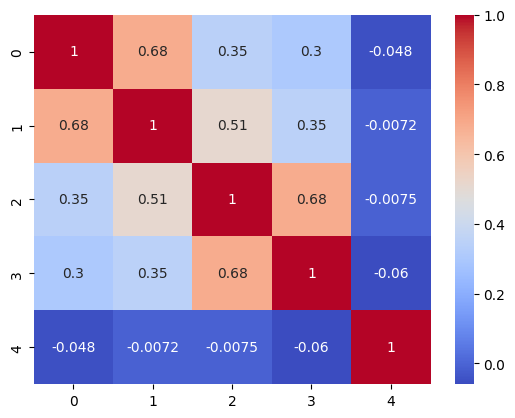

In [17]:
# examine relationships among five selected features, along with LogReturn and CloseLag1
XStudy = DKNG.select('HMLLag1','HMLLag2','VolumeLag2','VolumeLag3','LogReturn')

# prepare correlation heat map using seaborn
corrMatrix = XStudy.corr()
print(corrMatrix)
sns.heatmap(corrMatrix, cmap='coolwarm', annot=True)
plt.show()

In [44]:
X = DKNG.select('HMLLag1','HMLLag2','VolumeLag2','VolumeLag3')

### Define Cross-Validation Training and Test Sets

In [45]:
# Splitting the datasets into train and test sets
# gap is the number of samples to exclude from 
# the end of each train set and before the next test set.
tscv = TimeSeriesSplit(gap=10, n_splits=5)

all_splits = list(tscv.split(X, y))
train_0, test_0 = all_splits[0]
train_1, test_1 = all_splits[1]
train_2, test_2 = all_splits[2]
train_3, test_3 = all_splits[3]
train_4, test_4 = all_splits[4]

# examine the objects created for cross-validation splits
print("type(all_splits):", type(all_splits), " outer list length", len(all_splits))
print()
print("train_0 has",len(train_0),"with indices from ",min(train_0),"to",max(train_0))
print("test_0 has",len(test_0),"with indices from ",min(test_0),"to",max(test_0))
print()
print("train_1 has",len(train_1),"with indices from ",min(train_1),"to",max(train_1))
print("test_1 has",len(test_1),"with indices from ",min(test_1),"to",max(test_1))
print()
print("train_2 has",len(train_2),"with indices from ",min(train_2),"to",max(train_2))
print("test_2 has",len(test_2),"with indices from ",min(test_2),"to",max(test_2))
print()
print("train_3 has",len(train_3),"with indices from ",min(train_3),"to",max(train_3))
print("test_3 has",len(test_3),"with indices from ",min(test_3),"to",max(test_3))
print()
print("train_4 has",len(train_4),"with indices from ",min(train_4),"to",max(train_4))
print("test_4 has",len(test_4),"with indices from ",min(test_4),"to",max(test_4))

# to see all indices we can uncomment these statements
# print("elements of all_splits list of lists,\n shows index numbers for each the five lists")
# print(all_splits)

type(all_splits): <class 'list'>  outer list length 5

train_0 has 241 with indices from  0 to 240
test_0 has 248 with indices from  251 to 498

train_1 has 489 with indices from  0 to 488
test_1 has 248 with indices from  499 to 746

train_2 has 737 with indices from  0 to 736
test_2 has 248 with indices from  747 to 994

train_3 has 985 with indices from  0 to 984
test_3 has 248 with indices from  995 to 1242

train_4 has 1233 with indices from  0 to 1232
test_4 has 248 with indices from  1243 to 1490


### Baseline XGBoost Model

In [46]:
model = XGBClassifier(objective='binary:logistic', n_estimators=1000, random_state=2025)

### Evaluate Model Function

In [47]:
def evaluate(model, X, y, cv, model_prop=None, model_step=None):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["accuracy"],
        return_estimator=model_prop is not None,
    )
    if model_prop is not None:
        if model_step is not None:
            values = [
                getattr(m[model_step], model_prop) for m in cv_results["estimator"]
            ]
        else:
            values = [getattr(m, model_prop) for m in cv_results["estimator"]]
        print(f"Mean model.{model_prop} = {np.mean(values)}")
    accuracy = -cv_results["test_accuracy"]

    # print used in earlier testing
    # print(
    #    f"Mean Accuracy:     {-accuracy.mean():.3f} +/- {accuracy.std():.3f}\n"
    # )
    return (-accuracy.mean(), accuracy.std())
    
accuracyMean, accuracyStd = evaluate(model, X, y, cv=tscv, model_prop="n_estimators")
print(f"Mean Accuracy:     {accuracyMean:.3f} +/- {accuracyStd:.3f}\n")

Mean model.n_estimators = 1000.0
Mean Accuracy:     0.496 +/- 0.055



### Randomized Search for Optimal Hyperparameter Settings

In [48]:
# Randomized search to find the best set of hyperparameters

param_dist = {
    'max_depth': randint(3, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 1),
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': randint(100, 1000),
}
xgb_model = xgb.XGBClassifier(objective='binary:logistic',  eval_metric='logloss', random_state=2025)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=100, # Number of parameter settings that are sampled.
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1 # Use all available cores
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'learning_rate': 0.089231445399296, 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 273, 'subsample': 0.5038274263508563}
Best score: 0.4991935483870968


### Evaluation Visualizations

In [49]:
def eval_viz(model,X,y,ModelType):
    ypred = model.predict(X)
    RocCurveDisplay.from_predictions(y, ypred)
    
    print(ModelType+" Confusion Matrix")
    print(confusion_matrix(y, ypred))
    disp = ConfusionMatrixDisplay.from_predictions(y, ypred,normalize='true',
                                  display_labels =["Negative Return","Positive Return"],
                                                  cmap = plt.cm.Blues)
    plt.title(ModelType+" Confusion Matrix for Returns")
    plt.xlabel("Predicted Return")
    plt.ylabel("Actual Return")
    plt.tight_layout()
    plt.show()  
    
    print(classification_report(y, ypred, labels = ["0","1"]))

### Evaluate Model

<IPython.core.display.Javascript object>


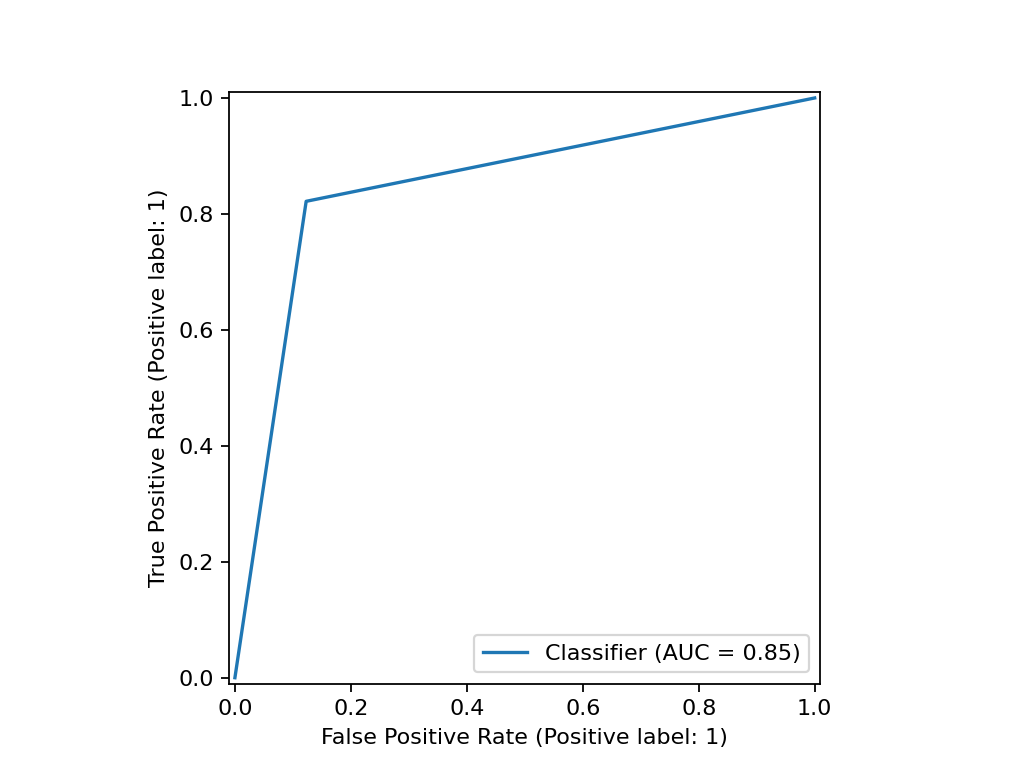

XGBoost Confusion Matrix
[[678  95]
 [128 590]]


<IPython.core.display.Javascript object>


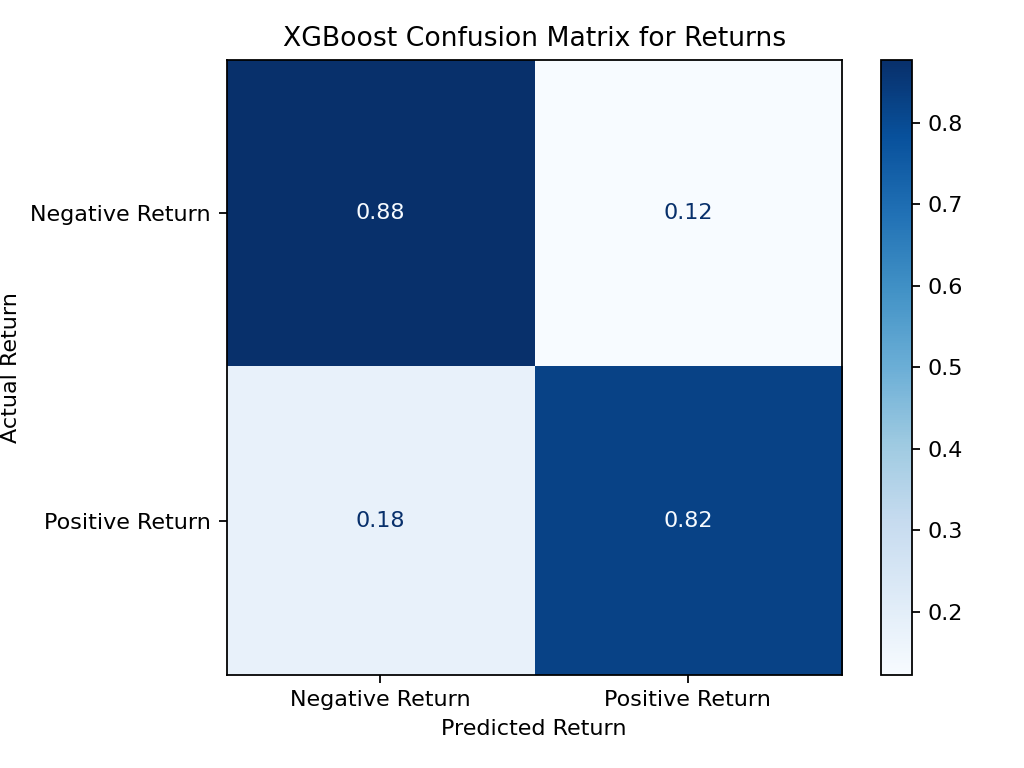

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       773
           1       0.86      0.82      0.84       718

   micro avg       0.85      0.85      0.85      1491
   macro avg       0.85      0.85      0.85      1491
weighted avg       0.85      0.85      0.85      1491



In [51]:
# final model evaluation
finalModel = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=2025,
    max_depth=9,
    min_child_weight=9,
    subsample=0.5038274263508563,
    learning_rate=0.089231445399296,
    n_estimators=273,
)
%matplotlib notebook

XGB_Model = finalModel.fit(X, y)

eval_viz(XGB_Model,X,y,"XGBoost")

### Baseline Logistic Regression

In [52]:
from sklearn.linear_model import LogisticRegression

logModel = LogisticRegression()

accuracyMean, accuracyStd = evaluate(logModel, X, y, cv=tscv, model_prop="C")
print(f"Mean Accuracy:     {accuracyMean:.3f} +/- {accuracyStd:.3f}\n")

Mean model.C = 1.0
Mean Accuracy:     0.498 +/- 0.056



### Find Optimal Hyperparameters for Logistic Regression

In [53]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)

param_dist = {
    'penalty': [None,'l2'],
    'C': uniform(1, 100),
    'solver': ['lbfgs','newton-cg','newton-cholesky','sag'],
}
log_model = LogisticRegression(random_state=2025,verbose=0)

random_search = RandomizedSearchCV(
    estimator=log_model,
    param_distributions=param_dist,
    n_iter=1000, 
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1,
    verbose=0
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/lmacph

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacph

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:239: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:239: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.1

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:239: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.1

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/pyt

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(


/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:239: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_w

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:239: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_w

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = s

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/pyt

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:239: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:239: UserWarning: Line Search failed
  warnings.warn("Line Search 

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:239: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/an

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:239: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.1

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:74: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_se

/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/scipy/optimize/_linesearch.py:312: LineSearchWarning: Rounding errors prevent the line search from converging
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/utils/optimize.py:239: UserWarning: Line Search failed
  warnings.warn("Line Search failed")
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.1

Best parameters: {'C': 1.2023196415325668, 'penalty': 'l2', 'solver': 'newton-cg'}
Best score: 0.5088709677419356


/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1186: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lmacphail/anaconda3/lib/python3.11/site-packages

### Evaluate Logistic Model

<IPython.core.display.Javascript object>


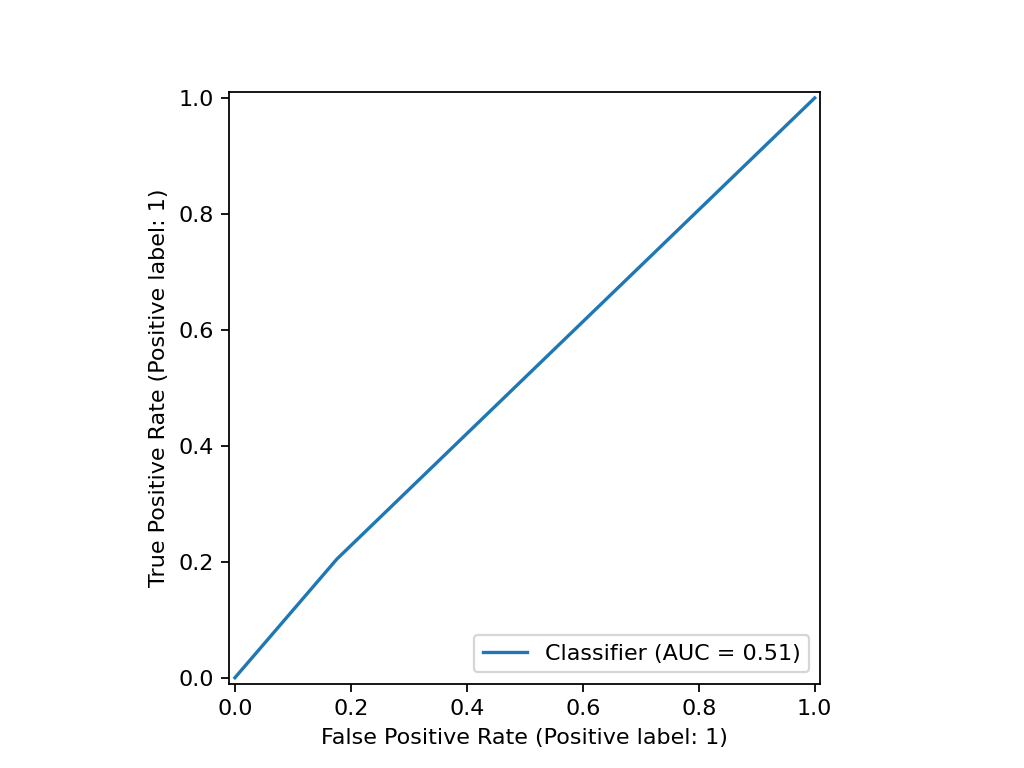

Logistic Regression Confusion Matrix
[[637 136]
 [571 147]]


<IPython.core.display.Javascript object>


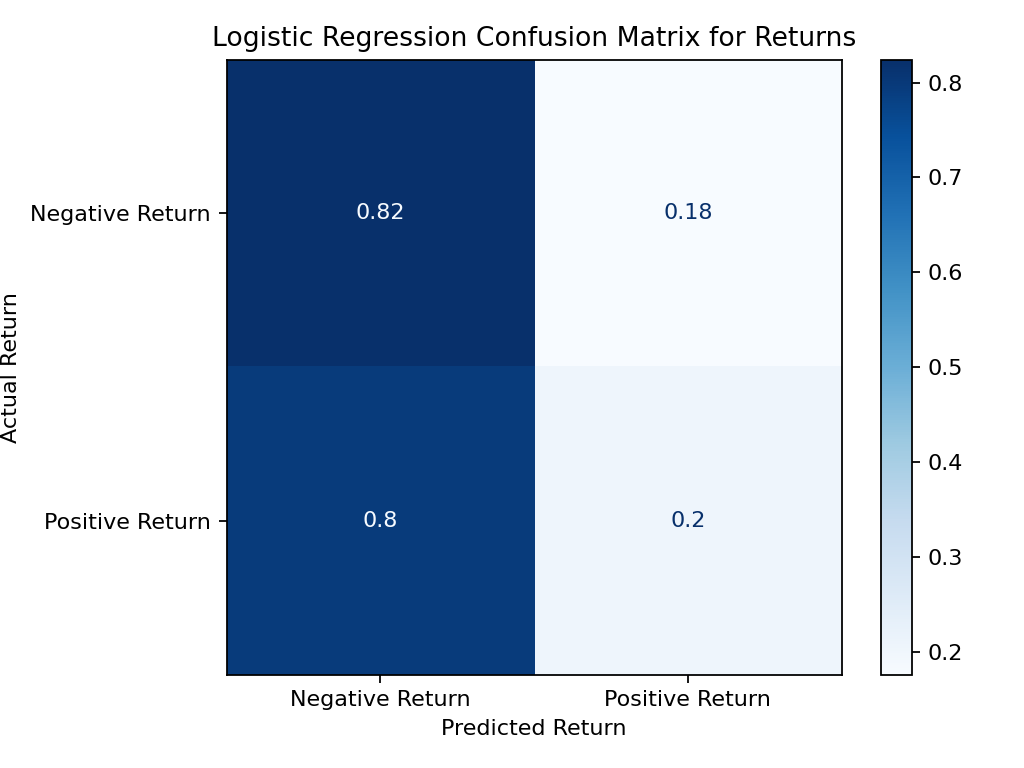

              precision    recall  f1-score   support

           0       0.53      0.82      0.64       773
           1       0.52      0.20      0.29       718

   micro avg       0.53      0.53      0.53      1491
   macro avg       0.52      0.51      0.47      1491
weighted avg       0.52      0.53      0.47      1491



In [54]:
# final model evaluation
finalLogModel = LogisticRegression(
    C = 1.2023196415325668,
    penalty='l2',
    solver='newton-cg'
)
%matplotlib notebook

finalLogModel.fit(X, y)
eval_viz(finalLogModel,X,y,"Logistic Regression")

### Support Vector Machines

In [55]:
from sklearn.svm import SVC

svm = SVC(kernel="rbf", class_weight="balanced")

accuracyMean, accuracyStd = evaluate(svm, X, y, cv=tscv, model_prop="C")
print(f"Mean Accuracy:     {accuracyMean:.3f} +/- {accuracyStd:.3f}\n")

Mean model.C = 1.0
Mean Accuracy:     0.515 +/- 0.019



### SVM Hyperparameter Search

In [56]:
param_grid = {
    
    'C': [0.1, 0.3, 1, 3, 10],
    'gamma': ["scale", 0.01, 0.1, 1, 3]
}

random_search = RandomizedSearchCV(
    estimator=svm,
    param_distributions=param_grid,
    n_iter=1000, 
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1,
    verbose=0
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'gamma': 'scale', 'C': 0.3}
Best score: 0.5193548387096774


### Evaluate Support Vector Machines

<IPython.core.display.Javascript object>


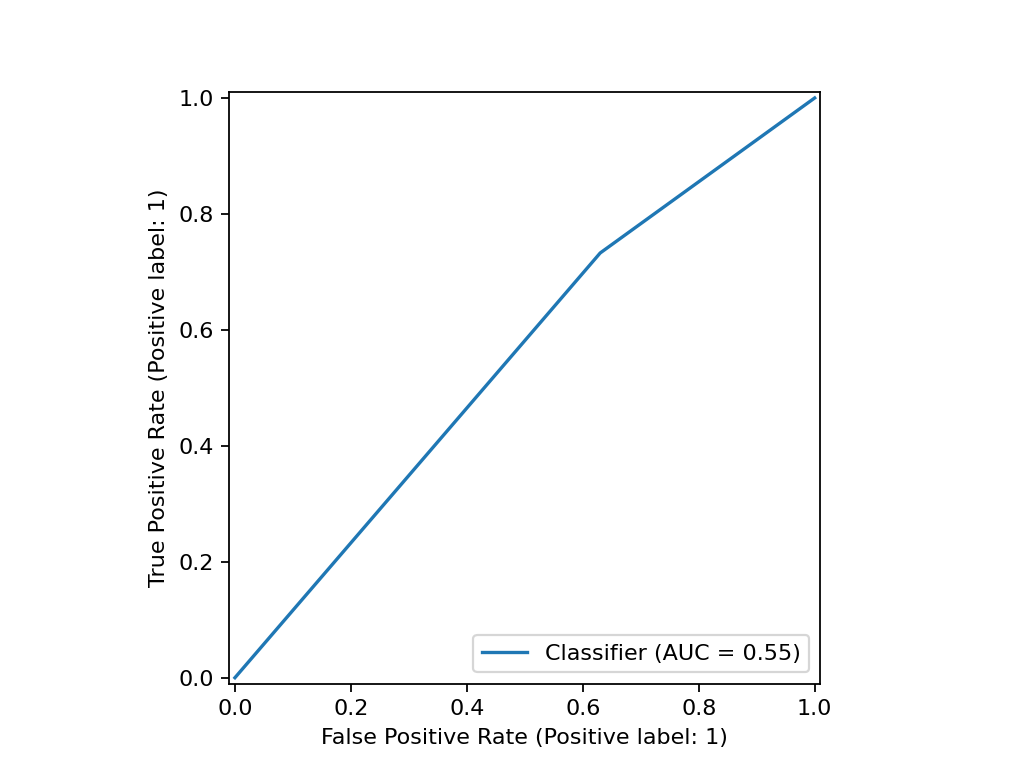

Support Vector Machines Confusion Matrix
[[286 487]
 [192 526]]


<IPython.core.display.Javascript object>


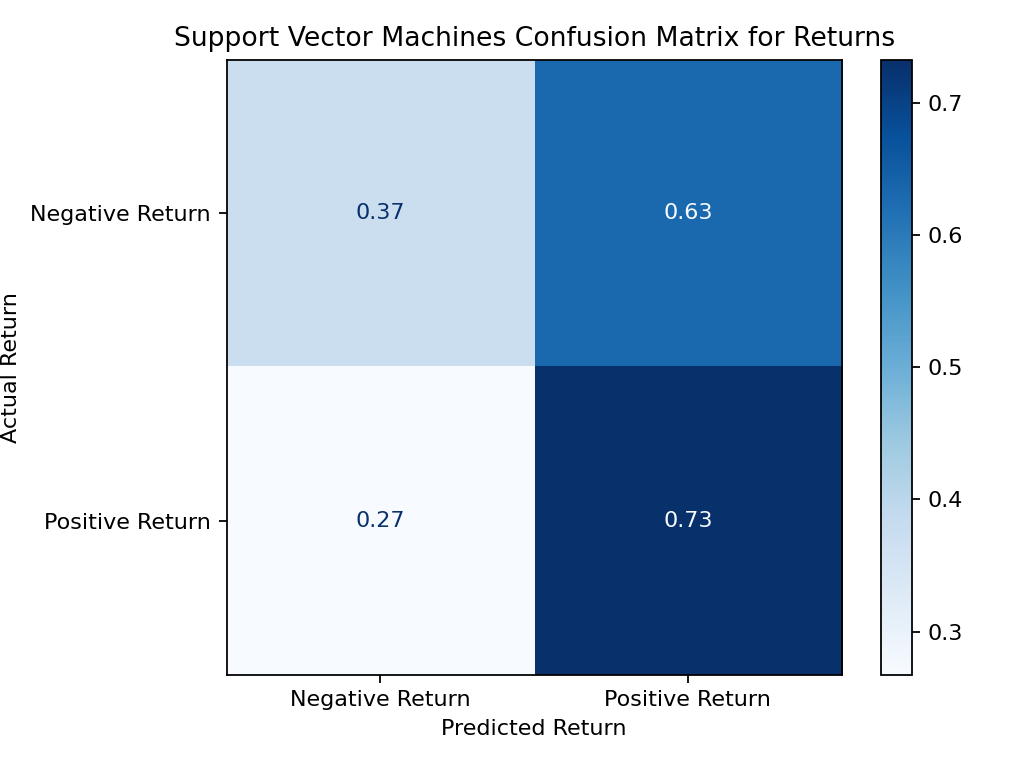

              precision    recall  f1-score   support

           0       0.60      0.37      0.46       773
           1       0.52      0.73      0.61       718

   micro avg       0.54      0.54      0.54      1491
   macro avg       0.56      0.55      0.53      1491
weighted avg       0.56      0.54      0.53      1491



In [57]:
# final model evaluation
finalSVM = SVC(
    kernel='rbf',
    C=0.3,
    gamma='scale',
    class_weight="balanced"
)

finalSVM.fit(X, y)
eval_viz(finalSVM,X,y,"Support Vector Machines")

### Light GBM

In [58]:
import lightgbm as lgbm

lgbm_model = lgbm.LGBMClassifier(random_state=2025,verbose=-1)

accuracyMean, accuracyStd = evaluate(lgbm_model, X, y, cv=tscv, model_prop="n_estimators")
print(f"Mean Accuracy:     {accuracyMean:.3f} +/- {accuracyStd:.3f}\n")

Mean model.n_estimators = 100.0
Mean Accuracy:     0.475 +/- 0.037



### Search Optimal Hyperparameters for Light GBM

In [59]:
param_dist = {
    'max_depth': randint(3, 10),
    'num_leaves': randint(10, 200),
    'min_data_in_leaf': randint(10, 1000),
    'learning_rate': uniform(0.01, 0.1),
    'bagging_fraction': uniform(0.1, .8),
}
lgbm_model = lgbm.LGBMClassifier(random_state=2025,verbose=-1)

random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist,
    n_iter=100, # Number of parameter settings that are sampled.
    scoring='accuracy',
    cv = TimeSeriesSplit(gap=10, n_splits=5),
    random_state=2025,
    n_jobs=-1 # Use all available cores
)

random_search.fit(X, y)

print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)

Best parameters: {'bagging_fraction': 0.8593922559923063, 'learning_rate': 0.04538905051570859, 'max_depth': 4, 'min_data_in_leaf': 226, 'num_leaves': 109}
Best score: 0.5129032258064516


### Evaluate Light GBM

<IPython.core.display.Javascript object>


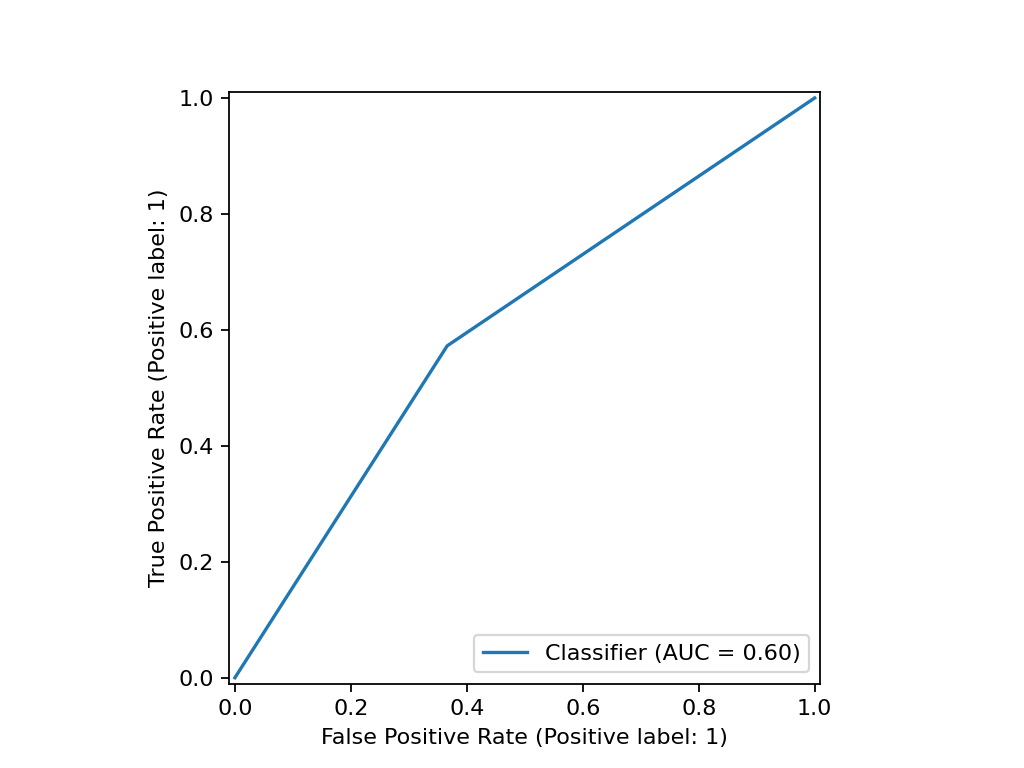

Light GBM Confusion Matrix
[[490 283]
 [307 411]]


<IPython.core.display.Javascript object>


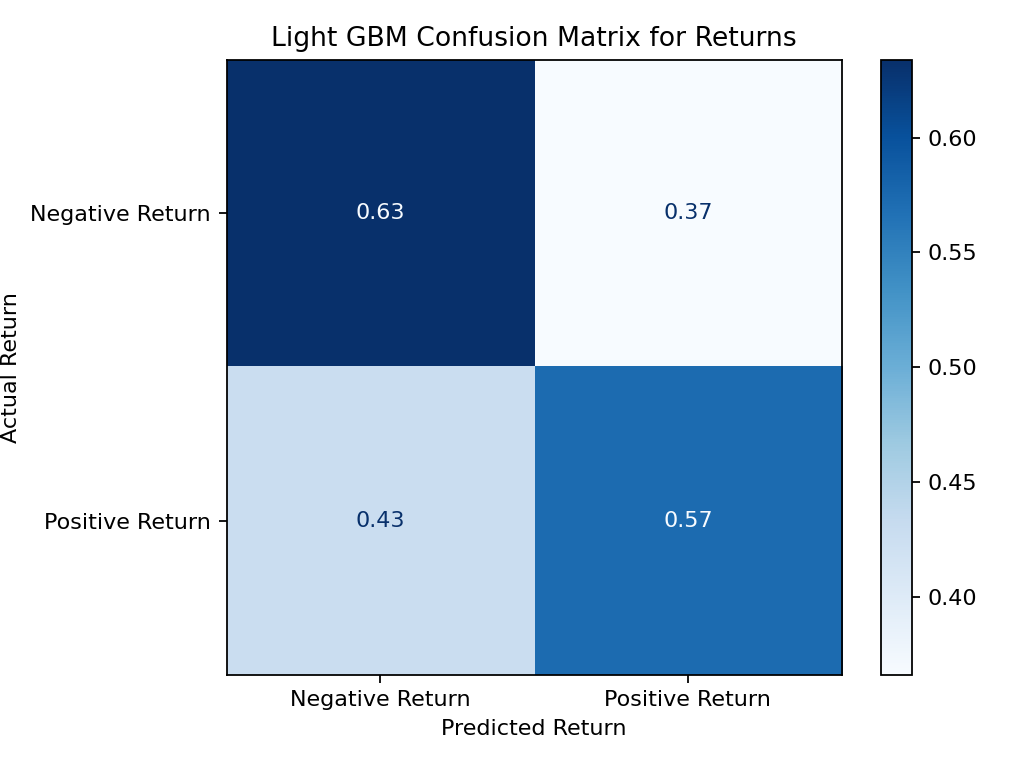

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       773
           1       0.59      0.57      0.58       718

   micro avg       0.60      0.60      0.60      1491
   macro avg       0.60      0.60      0.60      1491
weighted avg       0.60      0.60      0.60      1491



In [60]:
# final model evaluation
finalLGBM = lgbm.LGBMClassifier(
    max_depth=4,
    min_data_in_leaf = 226,
    num_leaves = 109,
    learning_rate = 0.04538905051570859,
    bagging_fraction = 0.8593922559923063
)

finalLGBM.fit(X, y)
eval_viz(finalLGBM,X,y,"Light GBM")

### Neural Network

Epoch 1/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - accuracy: 0.4965 - loss: 0.7947 
Epoch 2/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.5421 - loss: 0.6915
Epoch 3/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - accuracy: 0.5202 - loss: 0.7039
Epoch 4/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.5482 - loss: 0.6795
Epoch 5/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 599us/step - accuracy: 0.5502 - loss: 0.6892
Epoch 6/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - accuracy: 0.5302 - loss: 0.6885
Epoch 7/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - accuracy: 0.5635 - loss: 0.6724
Epoch 8/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - accuracy: 0.5345 - loss: 0.6909
Epoch 9/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 591us/step - accuracy: 0.5453 - loss: 0.6859
Epoch 10/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step - accuracy: 0.5163 - loss: 0.6785
Epoch 11/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.5434 - loss: 0.6815
Epoch 12/1000
47/47 ━━━━━━━━━

<IPython.core.display.Javascript object>


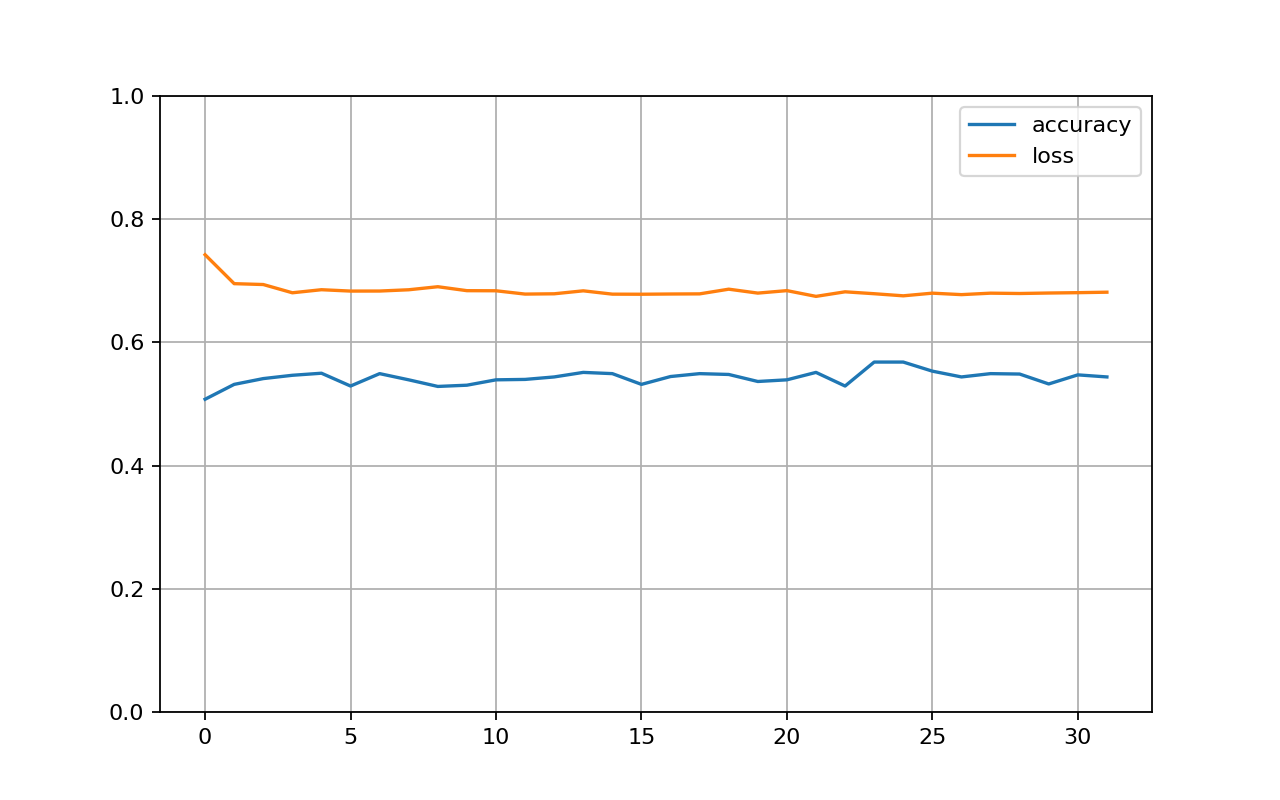

In [61]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout, Dense, Activation
from tensorflow import keras
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight

classes = np.arange(2)

w_arr = compute_class_weight("balanced",classes=classes, y=y.ravel())
class_weights = {int(c): float(w) for c, w in zip(classes, w_arr)}

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, monitor="loss",
)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

model_1 = models.Sequential()
model_1.add(layers.Dense(50, activation="relu", kernel_initializer="he_normal"))
model_1.add(BatchNormalization())
model_1.add(layers.Dense(25, activation="relu", kernel_initializer="he_normal"))
model_1.add(BatchNormalization())
model_1.add(layers.Dense(1, activation="sigmoid"))
model_1.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model_1.fit(
    X,
    y,
    class_weight = class_weights,
    epochs=1000,
    callbacks=[early_stopping_cb],
)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # set the vertical range to [0-1]
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step
              precision    recall  f1-score   support

           0       0.52      1.00      0.68       773
           1       0.00      0.00      0.00       718

    accuracy                           0.52      1491
   macro avg       0.26      0.50      0.34      1491
weighted avg       0.27      0.52      0.35      1491



<IPython.core.display.Javascript object>


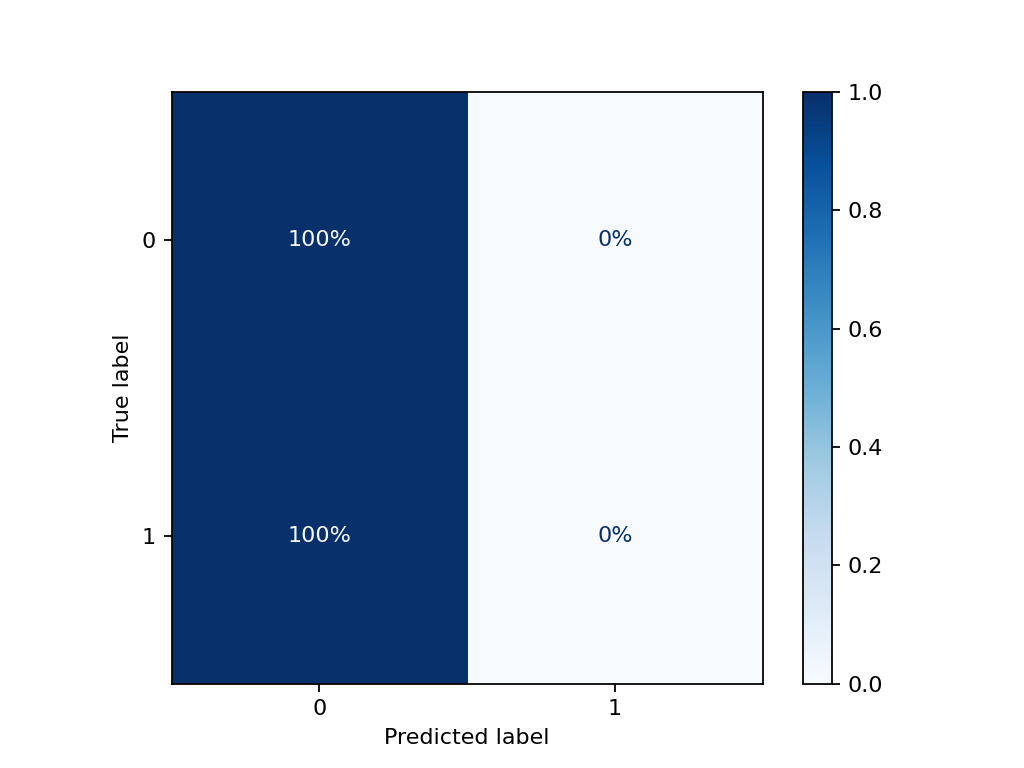

In [62]:
predicted = model_1.predict(X)
base_pred_y = predicted.argmax(axis=1)
print(classification_report(y, base_pred_y))
ConfusionMatrixDisplay.from_predictions(
    y, base_pred_y, normalize="true", values_format=".0%",cmap='Blues'
)

### Model Comparison

#### ROC Curve

<IPython.core.display.Javascript object>


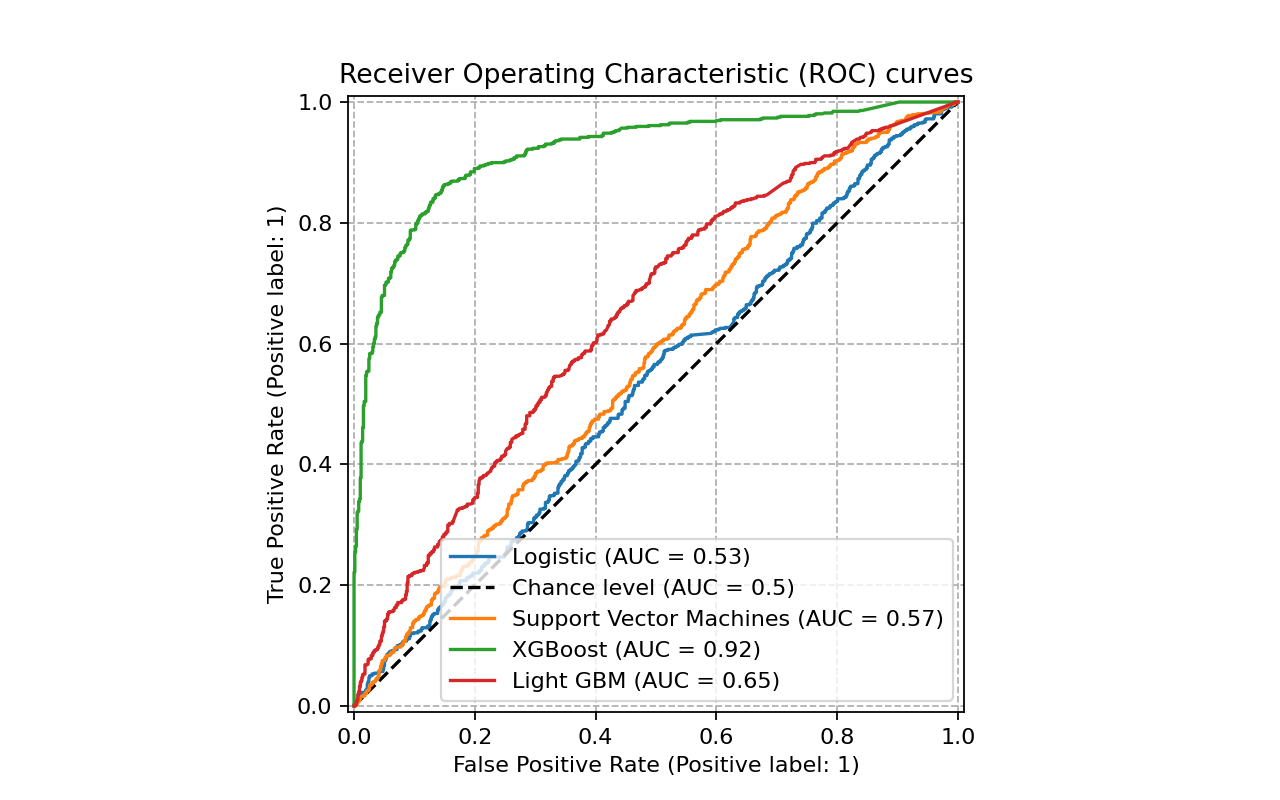

In [65]:
from sklearn.metrics import RocCurveDisplay


fig, ax = plt.subplots(1, 1, figsize=(8, 5))

RocCurveDisplay.from_estimator(finalLogModel, X, y, ax=ax, name="Logistic", plot_chance_level = True)
RocCurveDisplay.from_estimator(finalSVM, X, y, ax=ax, name="Support Vector Machines")
RocCurveDisplay.from_estimator(XGB_Model, X, y, ax=ax, name="XGBoost")
RocCurveDisplay.from_estimator(finalLGBM, X, y, ax=ax, name="Light GBM")

ax.set_title("Receiver Operating Characteristic (ROC) curves")

ax.grid(linestyle="--")

plt.legend()
plt.show()

#### Precision Recall Curve

<IPython.core.display.Javascript object>


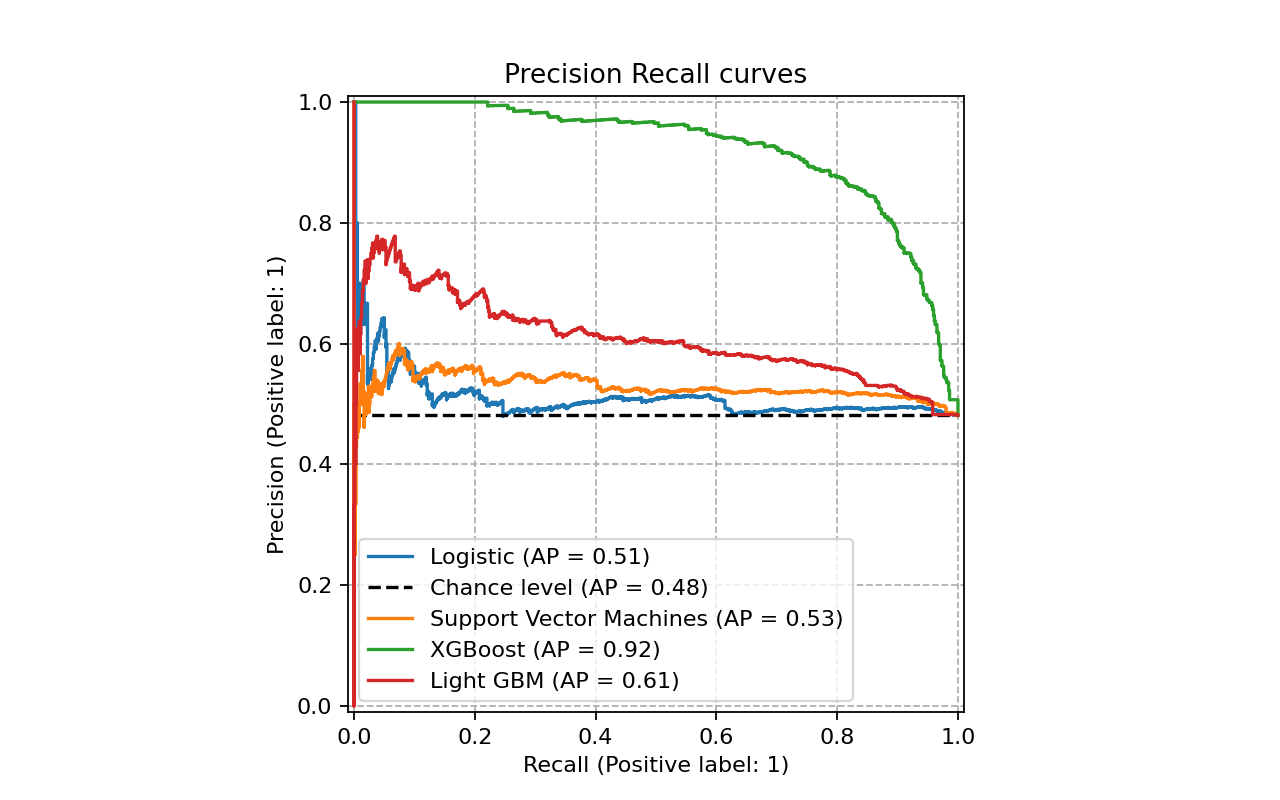

In [66]:
from sklearn.metrics import PrecisionRecallDisplay

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

PrecisionRecallDisplay.from_estimator(finalLogModel, X, y, ax=ax, name="Logistic", plot_chance_level = True)
PrecisionRecallDisplay.from_estimator(finalSVM, X, y, ax=ax, name="Support Vector Machines")
PrecisionRecallDisplay.from_estimator(XGB_Model, X, y, ax=ax, name="XGBoost")
PrecisionRecallDisplay.from_estimator(finalLGBM, X, y, ax=ax, name="Light GBM")

ax.set_title("Precision Recall curves")

ax.grid(linestyle="--")

plt.legend()
plt.show()